In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

In [116]:
df = pd.read_csv('../../Share/cpu_temp_24.csv', sep = '\t', parse_dates=True)

In [120]:
df = df[ (df['dates_hour'] > '2017-05') & (df['dates_hour'] < '2017-06')]

In [121]:
df.columns = ['dates_hour', 'temp']

In [122]:
df = df['temp']

In [123]:
df = df.reset_index()

In [125]:
df

,index,temp
0,17949,45.614006
1,17950,45.354776
2,17951,45.184314
3,17952,44.945099
4,17953,44.718489
...,...,...
739,18688,45.590884
740,18689,45.810799
741,18690,45.835203
742,18691,45.958123


In [126]:
df = pd.DataFrame(df['temp'])

In [127]:
df

,temp
0,45.614006
1,45.354776
2,45.184314
3,44.945099
4,44.718489
...,...
739,45.590884
740,45.810799
741,45.835203
742,45.958123


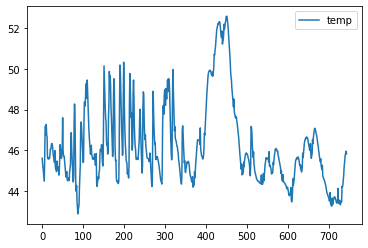

In [128]:
df.plot();

In [129]:
test_size = 48
test_ind = len(df) - test_size

In [130]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [131]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [132]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [133]:
scaled_train = scaler.transform(train)

In [134]:
scaled_test = scaler.transform(test)

In [135]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [136]:
length = 24

In [137]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size = 1)

In [138]:
X,y = generator[0]

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [140]:
n_features = 1

In [141]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [142]:
# model.summary()

In [143]:
from tensorflow.keras.callbacks import EarlyStopping

In [144]:
early_stop = EarlyStopping(monitor= 'val_loss', patience=2)

In [145]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length = length, batch_size=1)

In [147]:
model.fit_generator(generator, epochs= 20, validation_data=validation_generator) #, callbacks=[early_stop])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 672 steps, validate for 24 steps
Epoch 1/20
672/672 [==============================] - 40s 60ms/step - loss: 0.0081 - val_loss: 0.0019
Epoch 2/20
672/672 [==============================] - 41s 61ms/step - loss: 0.0064 - val_loss: 0.0014
Epoch 3/20
672/672 [==============================] - 42s 62ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 4/20
672/672 [==============================] - 42s 62ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 5/20
672/672 [==============================] - 42s 62ms/step - loss: 0.0036 - val_loss: 0.0011
Epoch 6/20
672/672 [==============================] - 40s 59ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 7/20
672/672 [==============================] - 37s 56ms/step - loss: 0.0033 - val_loss: 0.0010
Epoch 8/20
672/672 [==============================] - 37s 55ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 9/20
672/672 [==============================] - 37s 56ms/step - loss: 0.0030 - val_lo

In [148]:
losses = pd.DataFrame(model.history.history)

In [149]:
test_predictions =  []
first_eval_batch = scaled_train[-length:]
curr_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    curr_pred = model.predict(curr_batch)[0]
    test_predictions.append(curr_pred)
    curr_batch = np.append(curr_batch[:, 1:, :], [[curr_pred]], axis = 1 )

In [150]:
true_predication = scaler.inverse_transform(test_predictions)

In [151]:
test['predictions'] = true_predication

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


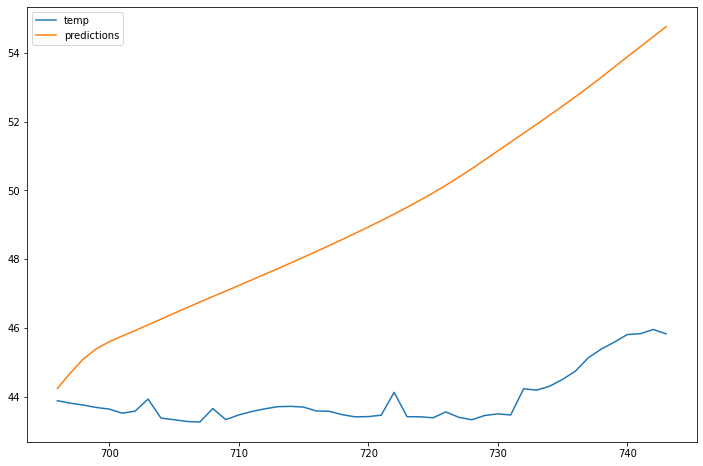

In [152]:
test.plot(figsize = (12,8))

In [153]:
full_scaler = MinMaxScaler()

In [154]:
scaled_full_data = full_scaler.fit_transform(df)

In [155]:
length = 24
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [156]:
model = Sequential()
model.add(LSTM(100, activation= 'relu', input_shape = (length, n_features)))
model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

In [157]:
model.fit_generator(generator, epochs=6)

  ...
    to  
  ['...']
Train for 720 steps
Epoch 1/6
720/720 [==============================] - 43s 59ms/step - loss: 0.0141
Epoch 2/6
720/720 [==============================] - 40s 55ms/step - loss: 0.0093
Epoch 3/6
720/720 [==============================] - 41s 56ms/step - loss: 0.0074
Epoch 4/6
720/720 [==============================] - 39s 55ms/step - loss: 0.0055
Epoch 5/6
720/720 [==============================] - 39s 55ms/step - loss: 0.0042
Epoch 6/6
720/720 [==============================] - 39s 54ms/step - loss: 0.0035


In [177]:
forecast =  []
period = 240 #24 hours 
first_eval_batch = scaled_train[-length:]
curr_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(period):
    if i%20 ==0:print(i)
    curr_pred = model.predict(curr_batch)[0]
    forecast.append(curr_pred)
    curr_batch = np.append(curr_batch[:, 1:, :], [[curr_pred]], axis = 1 )

0
20
40
60
80
100
120
140
160
180
200
220


In [178]:
forecast = scaler.inverse_transform(forecast)

In [179]:
forecast_index = pd.date_range(start = '2017-06-01', periods = period, freq="1H")

In [180]:
forecast_index

DatetimeIndex(['2017-06-01 00:00:00', '2017-06-01 01:00:00',
               '2017-06-01 02:00:00', '2017-06-01 03:00:00',
               '2017-06-01 04:00:00', '2017-06-01 05:00:00',
               '2017-06-01 06:00:00', '2017-06-01 07:00:00',
               '2017-06-01 08:00:00', '2017-06-01 09:00:00',
               ...
               '2017-06-10 14:00:00', '2017-06-10 15:00:00',
               '2017-06-10 16:00:00', '2017-06-10 17:00:00',
               '2017-06-10 18:00:00', '2017-06-10 19:00:00',
               '2017-06-10 20:00:00', '2017-06-10 21:00:00',
               '2017-06-10 22:00:00', '2017-06-10 23:00:00'],
              dtype='datetime64[ns]', length=240, freq='H')

In [181]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index , columns = ['Forecast'])

In [182]:
forecast_df

,Forecast
2017-06-01 00:00:00,4.430901e+01
2017-06-01 01:00:00,4.465984e+01
2017-06-01 02:00:00,4.496833e+01
2017-06-01 03:00:00,4.523337e+01
2017-06-01 04:00:00,4.546228e+01
...,...
2017-06-10 19:00:00,1.059515e+21
2017-06-10 20:00:00,1.440266e+21
2017-06-10 21:00:00,1.965403e+21
2017-06-10 22:00:00,2.677748e+21


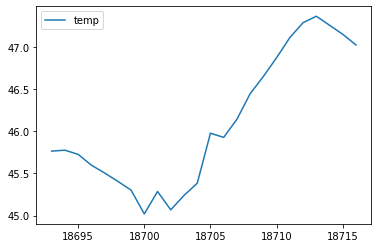

In [183]:
real = pd.read_csv('../../Share/cpu_temp_24.csv', sep = '\t', parse_dates=True)
real = real[ (real['dates_hour'] > '2017-06-01') & (real['dates_hour'] < '2017-06-02')]
ax = real.plot()

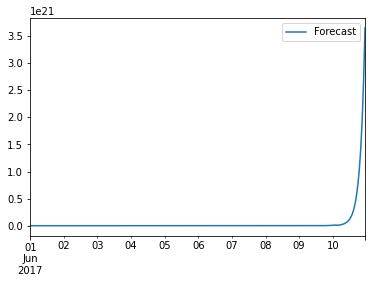

In [184]:
forecast_df.plot()